# Практическое задание 1. Обучение полносвязной нейронной сети.

In [1]:
import os
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

## 1. Загрузка данных (0 баллов)

Если вам требуется работать с каким-нибудь набором данных (dataset), то, прежде всего, проверьте, нет ли его среди встроенных наборов данных https://pytorch.org/vision/stable/datasets.html.

В текущем домашнем задании мы будем работать с набором данных FashionMNIST. Он присутствует в списке встроенных наборов данных, однако мы воспользуемся реализацией только для удобного и быстрого способа скачать наборы данных. Ниже предлагается реализовать собственный класс для считывания, обработки и упаковки данных.

In [2]:
training_data = datasets.FashionMNIST(
  root="data",
  train=True,
  download=True
)

test_data = datasets.FashionMNIST(
  root="data",
  train=False,
  download=True
)

Воспользуемся функцией загрузки данных из репозитория наборов данных.

In [3]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte     train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte     train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [4]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
  import os
  import gzip
  import numpy as np

  """Load MNIST data from `path`"""
  labels_path = os.path.join(path,
                            '%s-labels-idx1-ubyte.gz'
                            % kind)
  images_path = os.path.join(path,
                            '%s-images-idx3-ubyte.gz'
                            % kind)

  with gzip.open(labels_path, 'rb') as lbpath:
      labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                              offset=8)

  with gzip.open(images_path, 'rb') as imgpath:
    images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                           offset=16).reshape(len(labels), 784)

  return images, labels

Для удобства PyTorch предоставляет ряд базовых классов `Dataset, DataLoader`, от которых предлагается отнаследоваться при разработке пользовательских классов. Базовый класс `Dataset` используется для загрузки и обработки данных, класс `DataLoader` используется для управления процессом загрузки данных, позволяет в многопоточном режиме загружать данные и упаковывать их.
Эти вспомогательные классы находятся в модуле `torch.utils.data`.

При наследовании от класса `torch.utils.data.Dataset` требуется переопределить метод `__len__`, который возвращает количество примеров в наборе данных, а также метод `__getitem__`, который позволяет получить доступ к примеру из набора данных по индексу.

Реализуем класс для FasionMnist.

Элементами датасета должны являться пары '(np.array, int)', массив имеет размерность `(28, 28)`, тип элемента `np.float32`.

In [5]:
import os

class FashionMnist(Dataset):
  def __init__(self, path, train=True, image_transform=None,
               label_transform=None):
    if train:
      images, labels = load_mnist(os.path.join(path,"raw"))
    else:
      images, labels = load_mnist(os.path.join(path,"raw"), kind="t10k")

    self.image_transform = image_transform
    self.label_transform = label_transform
    self.images = images
    self.labels = labels

  def __len__(self,):
    length = len(self.images)
    return length

  def __getitem__(self, idx):
    img = self.image_transform(self.images[idx]) if self.image_transform is not None else self.images[idx]
    label = self.label_transform(self.labels[idx]) if self.label_transform is not None else self.labels[idx]
    return img, label


In [6]:
test_dataset = FashionMnist("data/FashionMNIST", train=False)
train_dataset = FashionMnist("data/FashionMNIST")

Визуализируйте случайные элементы набора данных.

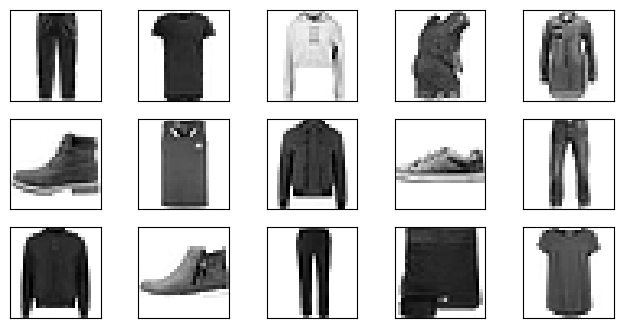

In [7]:
import random
random.seed(0)
plt.figure(figsize=(8, 4))
for i in range(15):
  plt.subplot(3, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_dataset[random.randint(0, len(train_dataset))][0].reshape(28, 28), cmap=plt.cm.binary)

В конструктор `Dataset` можно передать объект `torchvision.transforms`, который позволяет преобразовать исходные данные. Преобразование `torchvision.transforms.ToTensor` позволяет преобразоать данные из типа `PIL Image` и `numpy.float32` в тип `torch.float32`

Реализуйте собственную поддержку преобразований в `FashionMnist`. Проверьте, что приведение типов работает корректно.

In [8]:
class ToTensor:
  def __init__(self, is_target):
    self.dtype = torch.int64 if is_target else torch.bfloat16
    self.device = "cuda" if torch.cuda.is_available() else "cpu"

  """Convert ndarrays in sample to Tensors."""
  def __call__(self, sample):
    return torch.from_numpy(np.array(sample)).to(self.device, dtype=self.dtype)

In [9]:
transform_pic = ToTensor(False)
transform_target = ToTensor(True)

test_dataset = FashionMnist("data/FashionMNIST",
                            train=False,
                            image_transform=transform_pic,
                            label_transform=transform_target
                            )
train_dataset = FashionMnist("data/FashionMNIST",
                             image_transform=transform_pic,
                             label_transform=transform_target
                             )

In [10]:
print(f"The type of the data is {type(test_dataset[0][0])}")

The type of the data is <class 'torch.Tensor'>


Элементы набора данных могут быть объединены в пакеты (batch) явно и неявно. Если данные могут быть сконкатенированы или обЪединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [11]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=0, shuffle=True)
batch = next(iter(test_dataloader))

In [12]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 784])


Однако, если наша структура данных не позволяет нам использовать объединение по умолчанию, то можно написать собственную функцию, которая будет пакетировать данные.

Реализуйте функцию, преобразующую последовательность элементов массива в пакет (batch).

In [13]:
def collate(batch):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  imgs, labels = list(zip(*batch))
  imgs = torch.stack(imgs, dim=0).to(device, dtype=torch.bfloat16)
  labels = torch.stack(labels, dim=0).to(device, dtype=torch.int64)
  return imgs, labels

Убедитесть, что все работает корректно.

In [14]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=0,
                             shuffle=True, collate_fn=collate)
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=0,
                              shuffle=True, collate_fn=collate)
batch = next(iter(test_dataloader))

In [15]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 784])


## 2. Реализация модулей нейронной сети (15 баллов)

В этом разделе мы полностью реализуем модули для полносвязанной сети.

Для начала нам понадобится реализовать прямой и обратный проход через слои.

Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиент.

In [16]:
class IdentityFunction(Function):
  """
  We can implement our own custom autograd Functions by subclassing
  torch.autograd.Function and implementing the forward and backward passes
  which operate on Tensors.
  """
  @staticmethod
  def forward(ctx, input):
    """
    In the forward pass we receive a Tensor containing the input and return
    a Tensor containing the output. ctx is a context object that can be used
    to stash information for backward computation. You can cache arbitrary
    objects for use in the backward pass using the ctx.save_for_backward method.
    """
    return input

  @staticmethod
  def backward(ctx, grad_output):
    """
    In the backward pass we receive a Tensor containing the gradient of the loss
    with respect to the output, and we need to compute the gradient of the loss
    with respect to the input.
    """
    return grad_output

Разработанную функцию обернем классом `IdentityLayer`, все слои в `PyTorch` должны быть наследниками базового класса `nn.Module()`


In [17]:
class IdentityLayer(nn.Module):
  def __init__(self):
    # An identity layer does nothing
    super().__init__()
    self.identity = IdentityFunction.apply

  def forward(self, inp):
    # An identity layer just returns whatever it gets as input.
    return self.identity(inp)


### 2.1 Функция активации ReLU (1 балл)
Для начала реализуем функцию активации, слой нелинейности `ReLU(x) = max(x, 0)`. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения `ReLU` к входному массиву, метод `backward` - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [18]:
class ReLUFunction(Function):
  @staticmethod
  def forward(ctx, input):
    ctx.save_for_backward(input)
    output = input.clamp(min=0)
    return output

  @staticmethod
  def backward(ctx, grad_output):
    input, = ctx.saved_tensors
    grad_input = grad_output.clone()
    grad_input[input <= 0] = 0
    return grad_input

In [19]:
class ReLU(nn.Module):
  def __init__(self):
    super().__init__()
    self.relu = ReLUFunction.apply

  def forward(self, input):
    return self.relu(input)

Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [20]:
d_inp, d_batch = 15, 100
dtype = torch.float64
x_rand = torch.randn(d_batch, d_inp, generator=torch.manual_seed(0), requires_grad=True, dtype=dtype)

relu = ReLU()

assert gradcheck(relu, x_rand.to(dtype=torch.float64))

In [21]:
torch_relu = torch.relu
our_relu = ReLU()

assert torch.norm(torch_relu(x_rand.float()) - our_relu(x_rand)) < 1e-5

### 2.2 Линейный слой (linear, fully-connected) (3 балла)
Далее реализуем полносвязный слой без нелинейности. У слоя два набора параметра: матрица весов (weights) и вектор смещения (bias).

In [48]:
class LinearFunction(Function):
  @staticmethod
  def forward(ctx, inp, weights, bias):
    output = inp @ weights.t() + bias
    ctx.save_for_backward(inp, weights)
    return output

  @staticmethod
  def backward(ctx, grad_output):
    inp, weights = ctx.saved_tensors
    grad_input = grad_output @ weights
    grad_weight = grad_output.t() @ inp
    grad_bias = grad_output.clone()
    return grad_input, grad_weight, grad_bias


In [49]:
class Linear(nn.Module):
  def __init__(self, input_units, output_units):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(output_units, input_units)/100)
    self.bias = nn.Parameter(torch.rand(output_units)/10)
    self.Linear = LinearFunction.apply

  def forward(self, inp):
    return self.Linear(inp, self.weight, self.bias)

Проверим градиент, а также сравним с работой нашего модуля с имплементированным в `PyTorch`.

Проверка градиента:

In [50]:
d_outp = 27
linear = Linear(d_inp, d_outp).to(dtype)
assert gradcheck(linear, x_rand)

Сравнение с `PyTorch`.

In [51]:
weights = torch.randn(d_outp, d_inp, generator=torch.manual_seed(0))
bias = torch.randn(d_outp, generator=torch.manual_seed(0))
torch_linear = torch.nn.Linear(d_inp, d_outp).to(dtype)
our_linear = Linear(d_inp, d_outp).to(dtype)

state_dict = OrderedDict([("weight", weights), ("bias", bias)])
torch_linear.load_state_dict(state_dict)
our_linear.load_state_dict(state_dict)

assert torch.norm(torch_linear(x_rand) - our_linear(x_rand)) < 1e-5

### 2.3 LogSoftmax (Log + Softmax) (4 балла)

Для решения задачи многоклассовой классификации обычно используют `softmax` в качестве нелинейности на последнем слое, чтобы получить "оценку" вероятности классов для каждого объекта:$$\hat y = softmax(x)  = \bigl \{\frac {exp(x_i)}{\sum_j exp(x_j)} \bigr \}_{i=1}^K, \quad K - \text{число классов}$$В этом случае удобно оптимизировать логарифм правдоподобия:$$L(y, \hat y) = -\sum_{i=1}^K y_i \log \hat y_i \rightarrow \min,$$где $y_i=1$, если объект принадлежит $i$-му классу, и 0 иначе. Записанная в таком виде, эта функция потерь совпадает с выражением для кросс-энтропии. Очевидно, что ее также можно переписать через индексацию, если через $y_i$ обозначить класс данного объекта:$$L(y, \hat y) = - \log \hat y_{y_i} \rightarrow \min$$В таком виде ее удобно реализовывать.

Реализуйте слой `LogSoftmax` (без параметров). Метод `forward` должен вычислять логарифм от `softmax`, а метод `backward` - пропускать градиенты. В общем случае в промежуточных вычислениях `backward` получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде. Поэтому мы будем предполагать, что аргумент `grad_output` - это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

Для полного балла нужна имплементация с `Log-Sum-Exp trick`.

In [26]:
class LogSoftmaxFunction(Function):
  @staticmethod
  def forward(ctx, inp):
    max_inp = torch.max(inp, 1, keepdim=True)[0]
    logsumexp = max_inp + torch.log(torch.sum(torch.exp(inp - max_inp), 1, keepdim=True))
    logsoftmax =  inp - logsumexp
    ctx.save_for_backward(logsoftmax)
    return logsoftmax

  @staticmethod
  def backward(ctx, grad_output):
    '''
    d(logsoftmax_i)/dx_j = delta_ij - e(x_j)/sumexp = delta_ij - softmax_j
    dL/dx_i = \sum dL/dy_k * dy_k/dx_i = \sum grad_output * (delta_ik - softmax_i) = grad_output_i - softmax_i * \sum grad_output
    '''
    logsoftmax, = ctx.saved_tensors
    softmax = torch.exp(logsoftmax)
    grad_input = grad_output - softmax * grad_output.sum(dim=1, keepdim=True)
    return grad_input

In [27]:
class LogSoftmax(nn.Module):
  def __init__(self):
    super().__init__()
    self.logsoftmax = LogSoftmaxFunction.apply

  def forward(self, input):
    return self.logsoftmax(input)

Проверка градиентов.

In [28]:
logsoftmax = LogSoftmax()
assert gradcheck(logsoftmax, x_rand)

assert torch.norm(nn.LogSoftmax()(x_rand) - logsoftmax(x_rand)) < 1e-5

/Users/philurame/Downloads/global_venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


### 2.4 Dropout (2 балла)
Реализуйте слой Dropout.

In [29]:
class DropoutFunction(Function):
  @staticmethod
  def forward(ctx, inp, p):
    mask_not_zero = torch.rand_like(inp) < 1 - p
    ctx.save_for_backward(mask_not_zero)
    ctx.p = p
    return inp * mask_not_zero * (1 / (1 - p))

  @staticmethod
  def backward(ctx, grad_output):
    mask_not_zero, = ctx.saved_tensors
    return grad_output * mask_not_zero * (1 / (1 - ctx.p)), None
        

In [30]:
class Dropout(nn.Module):
  def __init__(self, p):
    super().__init__()
    self.p = p
    self.dropout = DropoutFunction.apply
      
  def forward(self, input):
    if self.training and self.p > 0:
      return self.dropout(input, self.p)
    return input

### 2.5 CrossEntropy (5 баллов)

При решении задачи многоклассовой классификации мы будет использовать в качестве функции потерь **кроссэнтропию, совместимую с `LogSoftmax` активацией**. 

Реализуйте эту функцию потерь. В разделе 2.3 приведены полезные формулы.

In [31]:
'''
реализуем NLL Loss, тк мы хотим его совместить с LogSOdftmax, a не переписывать все, так ведь?
'''

class CrossEntropyFunction(Function):
  @staticmethod
  def forward(ctx, activations, target):
    target_activations = -activations.gather(1, target.view(-1, 1))
    ctx.save_for_backward(target, torch.tensor(activations.shape))
    return target_activations.mean()

  @staticmethod
  def backward(ctx, grad_output):
    target, act_shape = ctx.saved_tensors
    grad_input = torch.zeros(act_shape.tolist(), dtype=grad_output.dtype, device=grad_output.device)    
    grad_input.scatter_(1, target.view(-1, 1), -1)
    return grad_output * grad_input / act_shape[0], None

class CrossEntropy(nn.Module):
  def __init__(self, ):
    super().__init__()
    self.cross_entropy = CrossEntropyFunction.apply

  def forward(self, activations, target):
    return self.cross_entropy(activations, target)

In [32]:
num_classes = 10

cross_entropy = CrossEntropy()
target = torch.randint(0, num_classes, (x_rand.shape[0],), dtype=torch.int64, generator=torch.manual_seed(0))

assert gradcheck(cross_entropy, (x_rand, target))

torch_cross_entropy = torch.nn.NLLLoss()
torch_output = torch_cross_entropy(x_rand, target)
our_output = cross_entropy(x_rand, target)

assert torch.norm(torch_cross_entropy(x_rand, target) - cross_entropy(x_rand, target)) < 1e-5

## 3. Сборка и обучение нейронной сети (5 баллов)

Реализуйте из ваших блоков персептрон и обучите его, залоггировав итоговый лосс и метрику на валидационной выборке. **(1 балл)**

Подсказка: вытягиваем картинку в вектор с помощью [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

In [52]:
class Network(nn.Module):
  def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
               num_classes=10, dropout_p=0.1):
    super().__init__()
    self.enc = nn.Sequential(nn.Flatten(), Linear(input_size, hidden_layers_size), Dropout(dropout_p), ReLU())
    self.dec = Linear(hidden_layers_size, num_classes)

    latents = []
    for _ in range(num_layers-2):
      latents.extend([Linear(hidden_layers_size, hidden_layers_size), Dropout(dropout_p), ReLU()])
    self.latents = nn.Sequential(*latents)

    self.logsoftmax = LogSoftmax()

  def forward(self, inp):
    emb = self.enc(inp)
    latent = self.latents(emb)
    logits = self.dec(latent)
    return self.logsoftmax(logits)

  def predict(self, inp):
    '''
    looks like not efficient(
    '''
    is_train = self.training
    self.eval()
    prediction = self.forward(inp).argmax(dim=1)
    if is_train: self.train()
    return prediction

Ниже приведены функции, реализующие обучение нейронной сети. В данном задании их предлагается просто переиспользовать.

In [34]:
class EmptyContext:
  def __enter__(self):
    pass

  def __exit__(self, *args):
    pass

In [35]:
# accuracy metric for our classififcation
def sum_accuracy(model_labels, labels):
  return torch.sum((model_labels == labels).float())

In [157]:
'''
no .to(device) since everything is already on the device
EmptyContext for what?
'''
def perform_epoch(model, loader, criterion, optimizer=None):
  is_train = optimizer is not None
  if is_train:
    model.train()
  else:
    model.eval()

  total_loss = 0
  total_acc = 0
  with EmptyContext() if is_train else torch.no_grad():
    for batch_data, batch_labels in loader:
      batch_data = batch_data
      batch_labels = batch_labels
      model_labels = model(batch_data)
      model_prediction = model.predict(batch_data) # need to use model twice because of dropout
      new_loss = criterion(model_labels, batch_labels)
      if is_train:
        optimizer.zero_grad()
        new_loss.backward()
        optimizer.step()

      one_batch_acc = sum_accuracy(model_prediction, batch_labels)

      total_loss += float(new_loss)
      total_acc += one_batch_acc
  return (total_loss / len(loader), total_acc / len(loader) / loader.batch_size)

Теперь обучим нашу нейронную сеть. В данном разделе будем использовать оптимизатор `Adam` с параметрами по умолчанию.

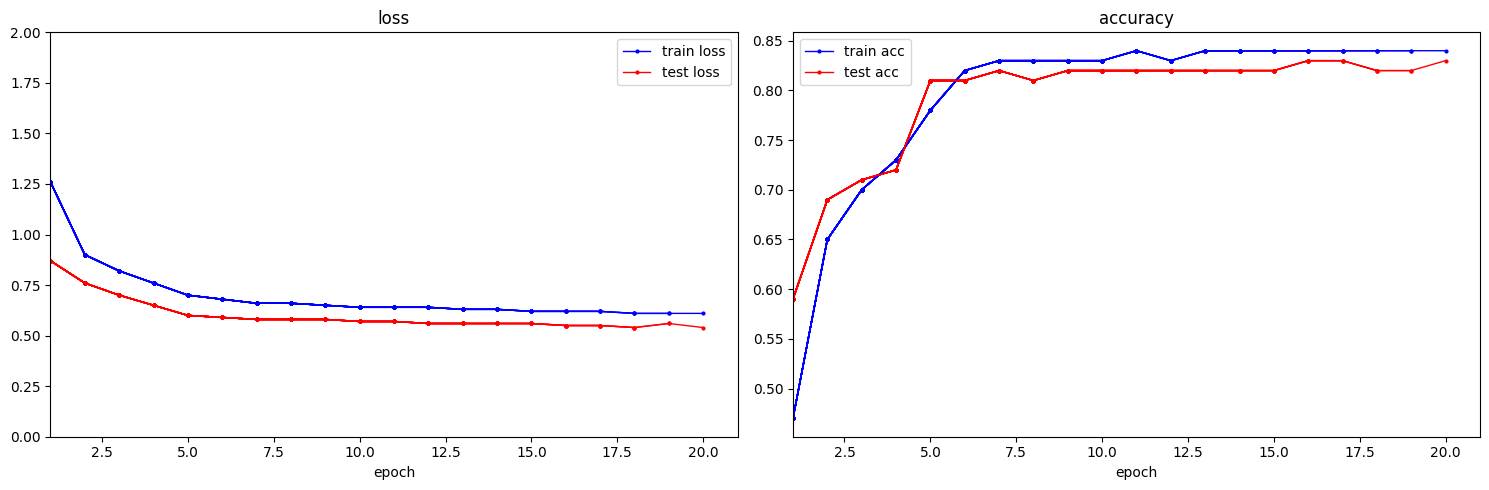

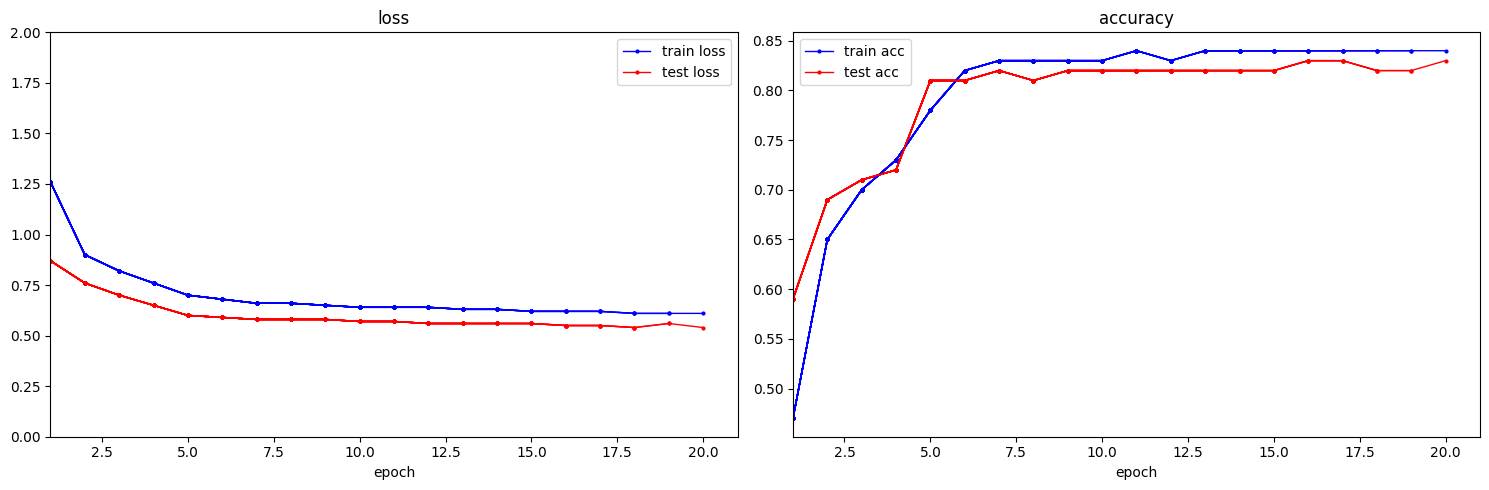

In [78]:
%matplotlib inline
import pylab as pl
import matplotlib.pyplot as plt
from IPython import display

model = Network()

optimizer = Adam(model.parameters())
criterion = CrossEntropy()

N_epochs = 20

torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # torch.device('mps')
model.to(device, dtype=torch.bfloat16)

tr_loss, tr_acc = [], []
tst_loss, tst_acc = [], []

fig, ax = pl.subplots(1,2, figsize=(15, 5))

for epoch in range(N_epochs):
  # train stats
  loss, acc = perform_epoch(model, train_dataloader, criterion, optimizer=optimizer)
  tr_loss.append(round(float(loss),2))
  tr_acc.append(round(float(acc),2))

  # val stats
  loss, acc = perform_epoch(model, test_dataloader, criterion)
  tst_loss.append(round(float(loss),2))
  tst_acc.append(round(float(acc),2))

  # plot
  display.clear_output(wait = True)
  ax[0].plot(range(1,len(tr_loss)+1), tr_loss, color='blue', label='train loss', marker='o', markersize=2, linewidth=1)
  ax[0].plot(range(1,len(tst_loss)+1), tst_loss, color='red', label='test loss', marker='o', markersize=2, linewidth=1)
  ax[1].plot(range(1,len(tr_acc)+1), tr_acc, color='blue', label='train acc', marker='o', markersize=2, linewidth=1)
  ax[1].plot(range(1,len(tst_acc)+1), tst_acc, color='red', label='test acc', marker='o', markersize=2, linewidth=1)
  if not epoch:
    ax[0].set_title('loss'), ax[1].set_title('accuracy')
    ax[0].set_xlabel('epoch'), ax[1].set_xlabel('epoch')
    ax[0].legend(), ax[1].legend()

  ax[0].set_xlim([1, epoch+2]), ax[1].set_xlim([1, epoch+2])
  ax[0].set_ylim([0,2])
  plt.tight_layout()
  display.display(fig)

Дальше **(4 балла)**:
- Проведите эксперименты с числом слоев.
- Постройте графики зависимости качества модели на тренировочной и тестовой выборках от числа слоев. Для получения статистически значимых результатов повторите эксперименты несколько раз.
- Сделайте выводы.

Training Loop для выполнения этой части задания можно и нужно улучшать, в том числе, добавляя более продвинутое логгирование эксперимента.

In [60]:
def get_stats(num_layers, dropout_p, seed, N_epochs=10):
  '''
  greed search func
  there is no overfit and accuracy is flat for epoch > 10 (for 5 layers)
  '''
  torch.manual_seed(seed)
  model = Network(num_layers=num_layers, dropout_p=dropout_p)
  optimizer = Adam(model.parameters())
  criterion = CrossEntropy()

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device, dtype=torch.bfloat16)

  max_tr_acc = 0
  max_tst_acc = 0
  for epoch in range(N_epochs):
    _, tr_acc  = perform_epoch(model, train_dataloader, criterion, optimizer=optimizer)
    _, tst_acc = perform_epoch(model, test_dataloader, criterion)

    max_tr_acc  = max(max_tr_acc, tr_acc)
    max_tst_acc = max(max_tst_acc, tst_acc)
  return (max_tr_acc, max_tst_acc)
        

grid_stats = dict(
  seed = list(range(4)), # monte-carlo 4 paths...
  dropout_p = [0, 0.4, 0.7],
  num_layers = [1, 5, 10, 20],
)

max_tr_acc = np.zeros((len(grid_stats['seed']), len(grid_stats['dropout_p']), len(grid_stats['num_layers'])))
max_tst_acc = np.zeros((len(grid_stats['seed']), len(grid_stats['dropout_p']), len(grid_stats['num_layers'])))

from tqdm import tqdm
for i, seed in tqdm(enumerate(grid_stats['seed']), total=len(grid_stats['seed'])):
  for j, dropout_p in enumerate(grid_stats['dropout_p']):
    for k, num_layers in enumerate(grid_stats['num_layers']):
      tracc, tstacc = get_stats(num_layers, dropout_p, seed)
      max_tr_acc[i, j, k] = tracc
      max_tst_acc[i, j, k] = tstacc


100%|██████████| 4/4 [1:52:01<00:00, 1680.27s/it]


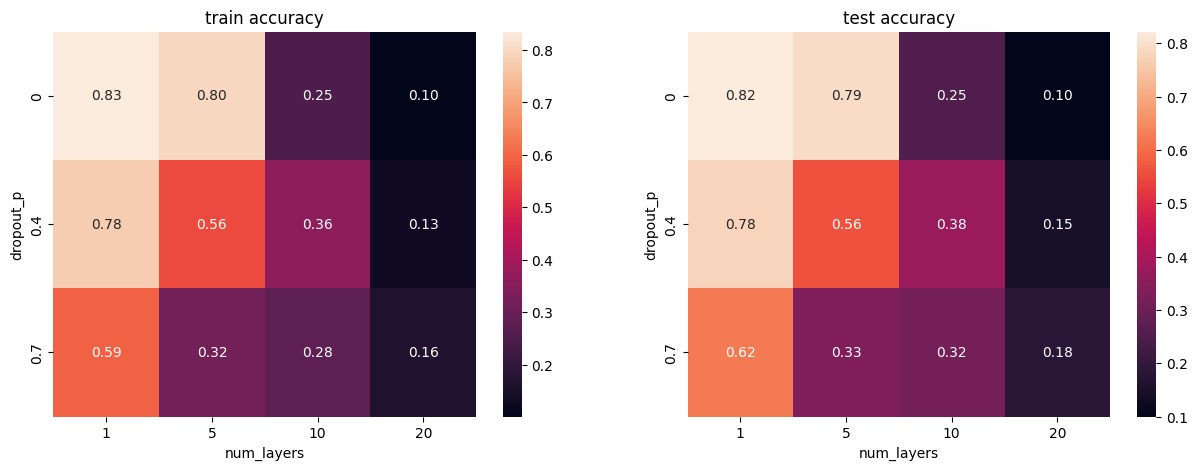

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(max_tr_acc.mean(axis=0), ax=ax[0], annot=True, fmt='.2f', 
            xticklabels=grid_stats['num_layers'], yticklabels=grid_stats['dropout_p'])
sns.heatmap(max_tst_acc. mean(axis=0), ax=ax[1], annot=True, fmt='.2f',
            xticklabels=grid_stats['num_layers'], yticklabels=grid_stats['dropout_p'])
ax[0].set_xlabel('num_layers'), ax[1].set_xlabel('num_layers')
ax[0].set_ylabel('dropout_p'), ax[1].set_ylabel('dropout_p')
ax[0].set_title('train accuracy'), ax[1].set_title('test accuracy');

- оверфита нет при num_layers < 10, поэтому и dropout на них был лишний. при этом он хоть немного, но помогает на num_layers >= 10...

## 4. Бонусная часть.

### 4.1 Реализация метода оптимизации (3 + 3 балла).
Реализуйте сами метод оптимизации  для рассмотренной выше архитектуры. Вы можете выбрать произвольный метод от градиентного спуска до современных вариантов. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с Adam.

**Дополнительные баллы** вы получите, если метод будет уникален среди сдавших задание.

In [124]:
class SGDOptimizer(Optimizer):
  '''
  SGD with momentum, dampening and nesterov
  '''

  def __init__(self, params, lr=1e-3, maximize=False, momentum=0, dampening=0, weight_decay=0, nesterov=False):
    '''
    sets defaults/user global settings to each param group.
    TODO: how to set different settings for each param group?
    '''
    defaults = dict(lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov, maximize=maximize)
    super(SGDOptimizer, self).__init__(params, defaults)

  def __setstate__(self, state):
    '''
    sets default state for each param. 
    TODO: do we need to do anything here if we set defaults in __init__?..
    '''
    super(SGDOptimizer, self).__setstate__(state)

  @torch.no_grad()
  def step(self) -> None:
    '''
    performs a step for each param group
    state is used to store momentum for each param
    '''
    
    # for each param group (with possible different learning rates)
    for group in self.param_groups:

      for p in group["params"]:

        grad = p.grad.clone()
        if grad is not None:

          # apply weight decay (L2 regularization)
          if group['weight_decay'] != 0:
            grad.add_(p, alpha=group['weight_decay'])

          # apply momentum
          if group["momentum"] != 0:

            # get previously stored momentum and update it if not None
            buffed_momentum = self.state[p].get("momentum_buffer")
            if buffed_momentum is None:
              buffed_momentum = torch.clone(grad).detach()
            else:
              # apply dampening
              buffed_momentum.mul_(group["momentum"]).add_(grad, alpha=1 - group['dampening'])
            
            # store updated momentum
            self.state[p]["momentum_buffer"] = buffed_momentum
            
            # apply nesterov
            if group["nesterov"]:
              grad.add_(buffed_momentum, alpha=group["momentum"])
            else:
              grad = buffed_momentum

          # apply step
          p.add_(grad, alpha=-group["lr"] if not group["maximize"] else group["lr"])

сравнение с торчовым оптимайзером

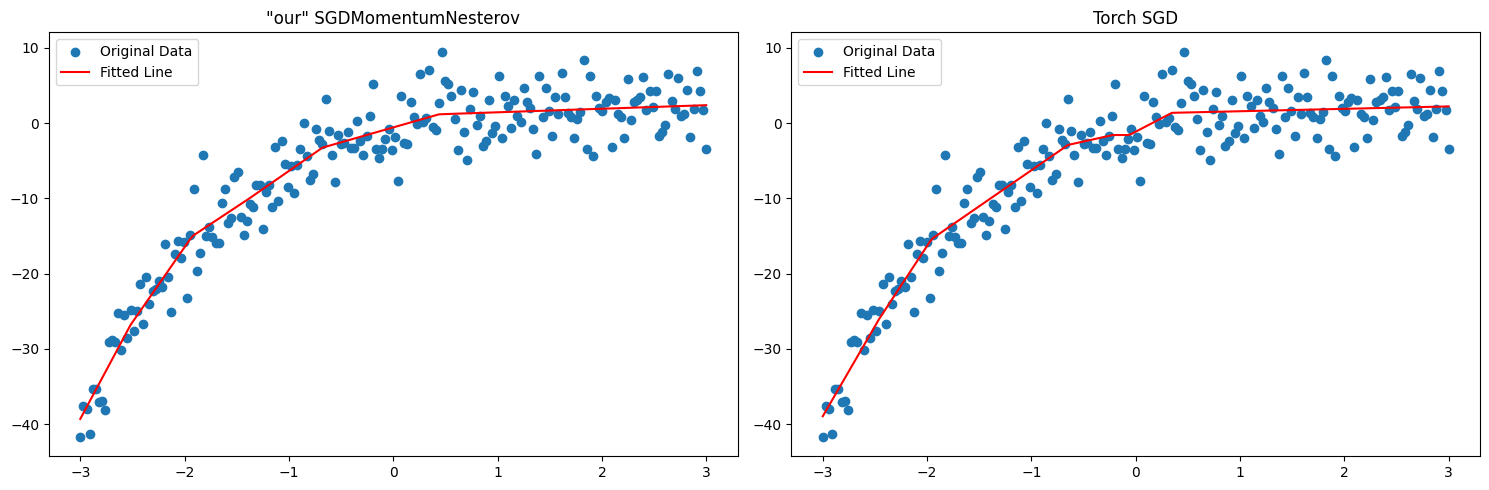

In [144]:
from torch.optim import SGD

CHOSED_PARAMS = 'SGDMomentumNesterov'
COMPARE_WITH = 'SGD' # ADAM ## p.s. will use the same params as CHOSED_PARAMS

all_params = dict(
  SGD = {},
  SGDMomentum = {'momentum': 0.9},
  SGDMomentumDampening = {'momentum': 0.9, 'dampening': 0.5},
  SGDMomentumNesterov = {'momentum': 0.9, 'nesterov': True},
)

x = np.linspace(-3, 3, 200).reshape(-1, 1)
y = 0.5 * x**3 - 2 * x**2 + 3 * x + np.random.randn(*x.shape) * 3

x_tensor = torch.from_numpy(x.astype(np.float32))
y_tensor = torch.from_numpy(y.astype(np.float32))

class SimplePolyModel(nn.Module):
  def __init__(self, torch_model):
    super(SimplePolyModel, self).__init__()
    self.torch_model = torch_model
    self.criterion = nn.MSELoss()
    if torch_model == True:
      self.layer1 = nn.Linear(1, 10)
      self.relu = nn.ReLU()
      self.layer2 = nn.Linear(10, 1)
    else:
      self.layer1 = Linear(1, 10)
      self.relu = ReLU()
      self.layer2 = Linear(10, 1)

  def forward(self, x):
    out = self.relu(self.layer1(x))
    out = self.layer2(out)
    return out
  
  def self_train(self):
    if self.torch_model == True:
      if COMPARE_WITH == 'SGD':
        optimizer = SGD(self.parameters(), lr=0.01, **all_params[CHOSED_PARAMS])
      elif COMPARE_WITH == 'ADAM':
        optimizer = Adam(self.parameters(), lr=0.01, **all_params[CHOSED_PARAMS])
    else:
      optimizer = SGDOptimizer(self.parameters(), lr=0.01, **all_params[CHOSED_PARAMS])

    for epoch in range(500):
      optimizer.zero_grad()
      outputs = self(x_tensor)
      loss = self.criterion(outputs, y_tensor)
      loss.backward()
      optimizer.step()

model_torch = SimplePolyModel(torch_model=True)
model_torch.self_train()
model_torch.eval()
model = SimplePolyModel(torch_model=False)
model.self_train()
model.eval()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
with torch.no_grad():
  predicted = model(x_tensor).numpy()
  predicted_torch = model_torch(x_tensor).numpy()

ax[0].scatter(x, y, label='Original Data')
ax[0].plot(x, predicted, 'r', label='Fitted Line')
ax[0].legend()
ax[1].scatter(x, y, label='Original Data')
ax[1].plot(x, predicted_torch, 'r', label='Fitted Line')
ax[1].legend()
ax[0].set_title(f'"our" {CHOSED_PARAMS}')
ax[1].set_title(f'Torch {COMPARE_WITH}')
plt.tight_layout();

### 4.2 Реализация современной функции активации (2 + 2 балла).
Реализуйте одну из активаций, предложенных на лекции или в статье. Например, `Hardswish`. Сравните сеть с вашей активацией и с `ReLU`.

**Дополнительные баллы** вы получите, если функция будет уникальна среди сдавших задание.

$$GELU(x)=x\cdot \Phi(x)=x\cdot\frac12\left(1+\text{erf}(x / \sqrt 2)\right)$$
$$GELU'(x)=x\cdot \Phi(x)=\Phi(x)+x\cdot p_{N(0,1)}(x),\quad p_{N(0,1)}(x)=\frac{1}{\sqrt{2\pi}}e^{-x^2/2}$$

In [152]:
import math

class GELUFunction(Function):
  @staticmethod
  def forward(ctx, x):
    phi_x = 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))
    ctx.save_for_backward(x, phi_x)
    return x * phi_x

  @staticmethod
  def backward(ctx, grad_output):
    x, phi_x = ctx.saved_tensors
    pdf = torch.exp(-0.5 * x ** 2) / math.sqrt(2.0 * math.pi)
    return grad_output * (phi_x + x * pdf)


class GELU(nn.Module):
  def __init__(self):
    super().__init__()
    self.GELU = GELUFunction.apply

  def forward(self, x):
    return self.GELU(x)

# check grads
assert gradcheck(GELU(), x_rand)
assert torch.norm(GELU().forward(x_rand) - torch.nn.functional.gelu(x_rand)) < 1e-5

- посмотрим на сеть с одним слоем с этой и relu активацией

In [162]:
class SimpleNetwork(nn.Module):
  def __init__(self, input_size=28*28, hidden_layers_size=32, num_classes=10, use_gelu=False):
    super().__init__()
    activation = GELU() if use_gelu else ReLU()
    self.enc = nn.Sequential(nn.Flatten(), Linear(input_size, hidden_layers_size), activation)
    self.dec = Linear(hidden_layers_size, num_classes)
    self.logsoftmax = LogSoftmax()

  def forward(self, inp):
    emb = self.enc(inp)
    logits = self.dec(emb)
    return self.logsoftmax(logits)

  def predict(self, inp):
    is_train = self.training
    self.eval()
    prediction = self.forward(inp).argmax(dim=1)
    if is_train: self.train()
    return prediction

criterion = CrossEntropy()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gelu_train_losses = []
relu_train_losses = []

gelu_val_accs = []
relu_val_accs = []

N_iters = 10
N_epochs = 10

for seed in tqdm(range(N_iters)):
  torch.manual_seed(seed)
  model_relu = SimpleNetwork(use_gelu=False).to(device, dtype=torch.bfloat16)
  torch.manual_seed(seed)
  model_gelu = SimpleNetwork(use_gelu=True ).to(device, dtype=torch.bfloat16)

  optimizer_relu = Adam(model_relu.parameters())
  optimizer_gelu = Adam(model_gelu.parameters())

  tr_loss_relu = []
  tr_loss_gelu = []
  val_acc_relu = []
  val_acc_gelu = []

  torch.manual_seed(seed)
  for epoch in range(N_epochs):
    # train stats
    loss, acc = perform_epoch(model_relu, train_dataloader, criterion, optimizer=optimizer_relu)
    tr_loss_relu.append(round(float(loss),3))

    # val stats
    loss, acc = perform_epoch(model_relu, test_dataloader, criterion)
    val_acc_relu.append(round(float(acc),3))

  torch.manual_seed(seed)
  for epoch in range(N_epochs):
    # train stats
    loss, acc = perform_epoch(model_gelu, train_dataloader, criterion, optimizer=optimizer_gelu)
    tr_loss_gelu.append(round(float(loss),3))

    # val stats
    loss, acc = perform_epoch(model_gelu, test_dataloader, criterion)
    val_acc_gelu.append(round(float(acc),3))
  
  gelu_train_losses.append(tr_loss_gelu)
  relu_train_losses.append(tr_loss_relu)
  gelu_val_accs.append(val_acc_gelu)
  relu_val_accs.append(val_acc_relu)

100%|██████████| 10/10 [20:22<00:00, 122.20s/it]


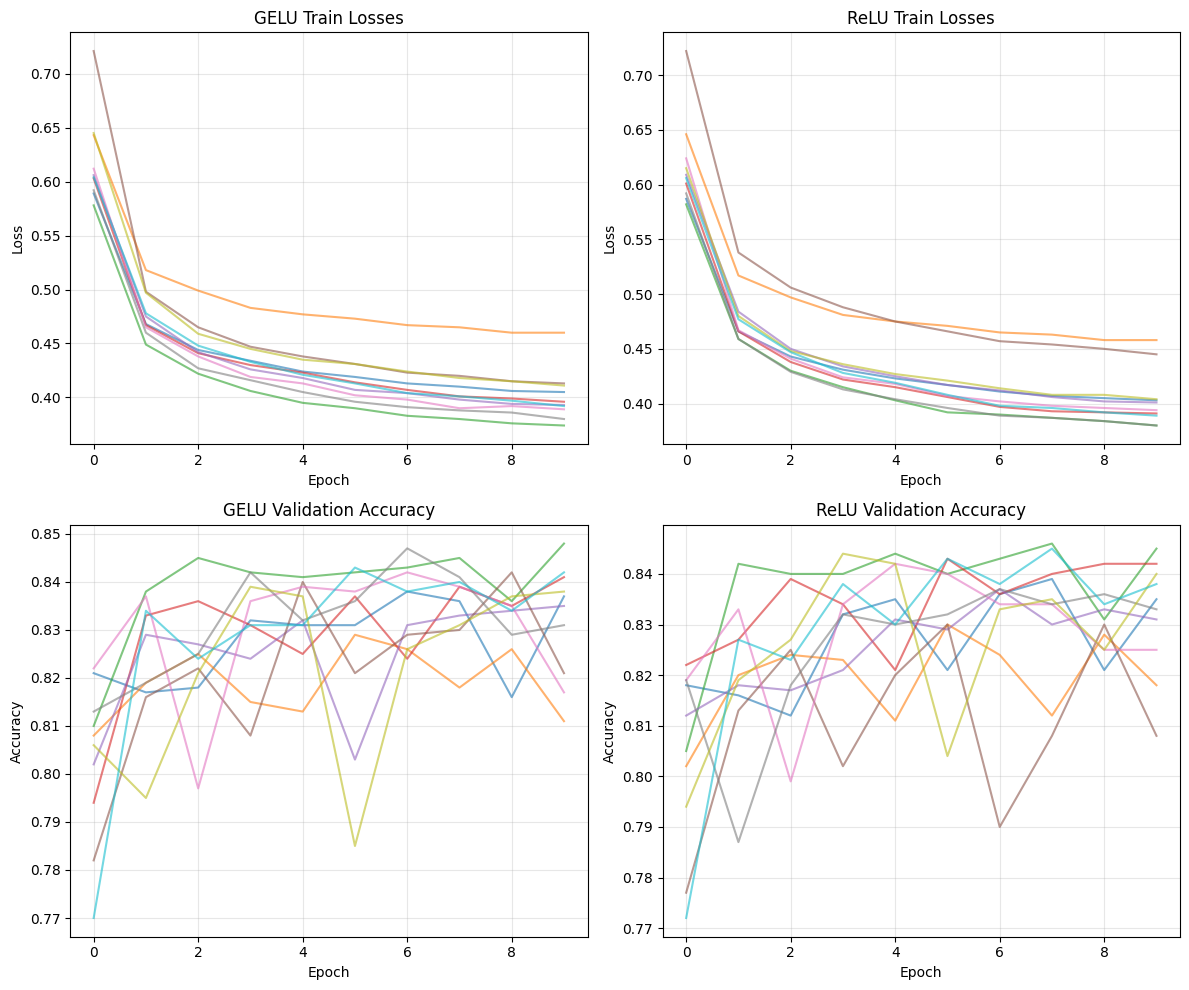

In [166]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# GELU train losses
for i, path in enumerate(gelu_train_losses):
  axs[0, 0].plot(path, alpha=0.6)
axs[0, 0].set_title('GELU Train Losses')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')

# ReLU train losses
for i, path in enumerate(relu_train_losses):
  axs[0, 1].plot(path, alpha=0.6)
axs[0, 1].set_title('ReLU Train Losses')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')

# GELU validation accuracies
for i, path in enumerate(gelu_val_accs):
  axs[1, 0].plot(path, alpha=0.6)
axs[1, 0].set_title('GELU Validation Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')

# ReLU validation accuracies
for i, path in enumerate(relu_val_accs):
  axs[1, 1].plot(path, alpha=0.6)
axs[1, 1].set_title('ReLU Validation Accuracy')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')

for ax in axs.flat:
  ax.grid(alpha=0.3)

plt.tight_layout();

- вот вообще нельзя их тут сравнивать, у них все статистики одинаковые на лоссе, у GELU чуть больше разброс из-за погрешностей подсчета erf, наверное